In [10]:
from osgeo import gdal, gdal_array, osr, ogr
import matplotlib.pyplot as plt
import numpy as np
import operator
from functools import reduce
import shapefile
import pngcanvas
import subprocess
import skimage.exposure as exposure
import skimage.io as io

## Image bands

In [2]:
# Load the source image into an array

src = "sat_image.png"
arr_1 = gdal.Open(src)

# We check what bands correspond to which color

for i in range(1, arr_1.RasterCount + 1):
    band = arr_1.GetRasterBand(i)
    # Print band type (this gives the color interpretation
    print(gdal.GetColorInterpretationName(band.GetColorInterpretation()))

Red
Green
Blue
Alpha


/opt/local/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/GDAL-3.7.2-py3.11-macosx-13.0-x86_64.egg/osgeo/gdal.py:290: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
# We count the number of bands, i.e., channels

print(arr_1.RasterCount)

# We fetch the bands

band1 = arr_1.GetRasterBand(1) # Red
band2 = arr_1.GetRasterBand(2) # Green
band3 = arr_1.GetRasterBand(3) # Blue
band4 = arr_1.GetRasterBand(4) # Image selection out of circle (alpha)

# We store in 3 different arrays

b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()
b4 = band4.ReadAsArray()

4


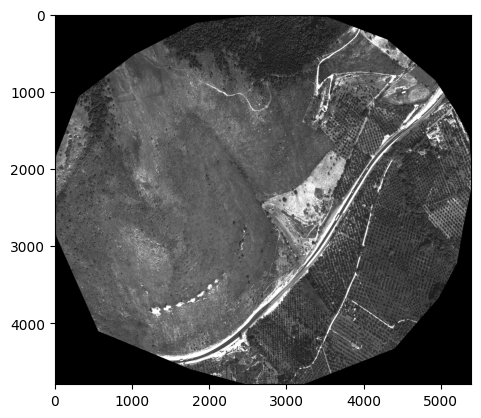

In [5]:
f = plt.figure()
plt.imshow(b2, cmap = 'grey')

In [6]:
# We can also convert everything into an array. We will have the three bands, and each band is a
# matrix for height and width

arr = gdal_array.LoadFile(src) # The image became a numpy array

## Creating histograms

A histogram shows the statistical frequency of data distribution within a dataset. In the case
of remote sensing, the dataset is an image. The data distribution is the frequency of pixels in
the range of 0 to 255, which is the range of 8-byte numbers that are used to store image
information on computers.
In an RGB image, color is represented as a 3-digit tuple with (0,0,0) being black and
(255,255,255) being white. We can graph the histogram of an image with the frequency of
each value along the y-axis and the range of 256 possible pixel values along the x-axis.

In [7]:
def histogram(a, bins=list(range(0, 256))):
    fa = a.flat  # makes everything a 1D array
    
    n = gdal_array.numpy.searchsorted(gdal_array.numpy.sort(fa), bins)
    n = gdal_array.numpy.concatenate([n, [len(fa)]])
    hist = n[1:]-n[:-1]
    return hist


im = "sat_image.png"
histograms = []
arr = gdal_array.LoadFile(im)
for b in arr: # gets the three bands
    histograms.append(histogram(b))

In [8]:
histograms
len(histograms)

4

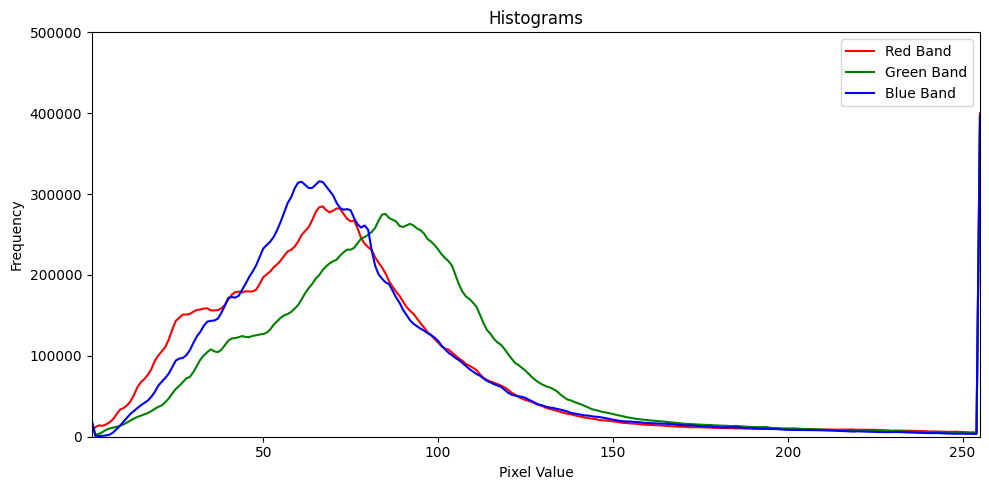

In [9]:
im = "sat_image.tiff"
arr = gdal_array.LoadFile(im)

histograms = [histogram(b) for b in arr]

# Plotting the histograms on the same figure
plt.figure(figsize=(10, 5))

plt.plot(histograms[0], color='r', label='Red Band')
plt.plot(histograms[1], color='g', label='Green Band')
plt.plot(histograms[2], color='b', label='Blue Band')

# If there's a fourth band and you want to plot its histogram:
# plt.plot(histograms[3], color='gray', label='Fourth Band')

plt.title('Histograms')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.xlim(1, 255)
plt.ylim(0, 0.5*1e6)

plt.tight_layout()
plt.show()

## Histogram equalization

In [12]:
image = io.imread("sat_image.png")

# Apply histogram equalization
equalized_image = exposure.equalize_hist(image)

# Convert the image to 'uint8' mode
equalized_image_uint8 = (equalized_image * 255).astype('uint8')

# Save the enhanced image as a PNG
io.imsave("enhanced_thermal_image.png", equalized_image_uint8)

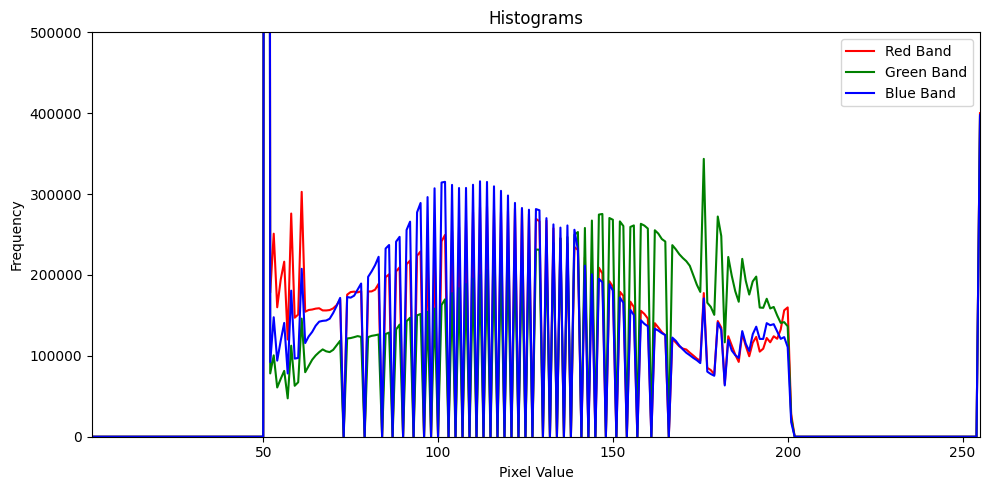

In [13]:
im = "enhanced_thermal_image.png"
arr = gdal_array.LoadFile(im)

histograms = [histogram(b) for b in arr]

# Plotting the histograms on the same figure
plt.figure(figsize=(10, 5))

plt.plot(histograms[0], color='r', label='Red Band')
plt.plot(histograms[1], color='g', label='Green Band')
plt.plot(histograms[2], color='b', label='Blue Band')

# If there's a fourth band and you want to plot its histogram:
# plt.plot(histograms[3], color='gray', label='Fourth Band')

plt.title('Histograms')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.xlim(1, 255)
plt.ylim(0, 0.5*1e6)

plt.tight_layout()
plt.show()

## Classify images skewed

In [16]:
# Input file name (thermal image)
src = "enhanced_thermal_image.png"
src_org = "sat_image.png"
# Output file name
tgt_2 = "classified_type_2.tiff"

# Load the image into numpy using gdal
srcArr = gdal_array.LoadFile(src)[1]

# Load the alpha band into numpy using gdal
alpha_band = gdal_array.LoadFile(src_org)[3]


###############################################
# Here I split the histogram into three main classes, the second class contains the trees reflactance
classes = np.array([0, 52, 54, 255])

lut = [[0, 0, 0], [0, 0, 0], [255, 255, 255], [0, 0, 0]]
###############################################

start = 1
# Set up the RGB color output image
rgb = np.zeros((3, srcArr.shape[0], srcArr.shape[1]), np.float32)

# Process all classes and assign colors
for i in range(len(classes)):
    mask = np.logical_and(start <= srcArr, srcArr <= classes[i])
    
    # Apply the alpha band as a mask to exclude unwanted areas
    mask = np.logical_and(mask, alpha_band > 0)

    for j in range(len(lut[i])):
        rgb[j] = np.choose(mask, (rgb[j], lut[i][j]))
    
    start = classes[i] + 1

# Save the image
output = gdal_array.SaveArray(rgb.astype(np.uint8), tgt_2, format="GTiff")
output = None


## Extracting features from images

We create shapefiles from raster images

In [17]:
# Thresholded input raster name
src = "classified_type_2.tiff"
# Output shapefile name
tgt = "extract.shp"
# OGR layer name
tgtLayer = "extract"


# Open the input raster
srcDS = gdal.Open(src)
# Grab the second band
band = srcDS.GetRasterBand(2)

In [18]:
import numpy as np

unique_vals = np.unique(band.ReadAsArray())
print(unique_vals)

[  0 255]


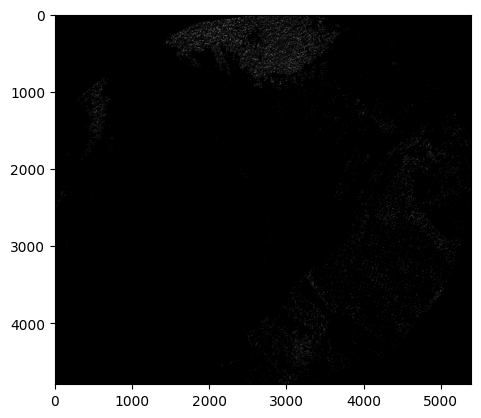

In [19]:
f = plt.figure()
plt.imshow(band.ReadAsArray(), cmap='gray')
plt.show()

In [20]:
print(srcDS.RasterCount)

# Force gdal to use the band as a mask
mask = srcDS.GetRasterBand(2)

#src_org = "sat_image.png"
#arr_org = gdal.Open(src_org)
#mask = arr_org.GetRasterBand(4)

# Set up the output shapefile
driver = ogr.GetDriverByName("ESRI Shapefile")
shp = driver.CreateDataSource(tgt)

# Copy the spatial reference  (We don't have any in our case...)
srs = osr.SpatialReference()
srs.ImportFromWkt(srcDS.GetProjectionRef())
layer = shp.CreateLayer(tgtLayer, srs = srs)

srcDS.GetProjectionRef()

# Set up the dbf file
fd = ogr.FieldDefn("DN", ogr.OFTInteger)
layer.CreateField(fd)
dst_field = 0

# Automatically extract features from an image!
extract = gdal.Polygonize(band, mask, layer, dst_field, [], None)

shp.SyncToDisk()

3


0

shp.SyncToDisk() is a method that writes the data stored in memory to the disk.

When you create a new vector layer using the CreateDataSource() method, the layer is created in memory, and any changes made to the layer are also stored in memory until you explicitly save the changes to disk using SyncToDisk(). This means that if you don't call SyncToDisk() after modifying the layer, any changes you made will be lost when you close the data source or exit the program.

### Analysis of the shapefile

In [21]:
r = shapefile.Reader("extract")

In [23]:
# This block calculates the total area of the considered raster image


src_org = gdal.Open("sat_image.png")
mask_band = src_org.GetRasterBand(4)  # Mask (alpha band)
mask_data = mask_band.ReadAsArray()


# Total (rectangular) area 
x = (r.bbox[2] - r.bbox[0])
y = (r.bbox[3] - r.bbox[1])

# Count the number of zero pixels (NO areas of interest) in the mask
mask_area_pixels = (mask_data == 0).sum()

# Total area under examination
mask_area = (x * y) - mask_area_pixels

print(mask_area)


20618283.0


In [24]:
num_records = r.numRecords
print("Number of records:", num_records)

print(r.shapeType) #polygon
print(r.shapes()[3])

shape = r.shape(100)
shape.points

Number of records: 61809
5
Shape #3: POLYGON


[(2691.0, 15.0),
 (2691.0, 16.0),
 (2692.0, 16.0),
 (2692.0, 15.0),
 (2691.0, 15.0)]

In [25]:
shapef = ogr.Open('extract.shp')
layer = shapef.GetLayer()

# Initialize a variable to store the total area
total_area = 0.0

# Iterate through the features and calculate their individual areas
for feature in layer:
    geometry = feature.GetGeometryRef()
    feature_area = geometry.GetArea()
    total_area += feature_area

print(total_area)

161466.0


In [26]:
(total_area/mask_area)*100  # The 0.8% of the image is covered with trees

0.7831204955330179

### Print the shapefile

In [81]:
r = shapefile.Reader("extract.shp")
xdist = r.bbox[2] - r.bbox[0]
ydist = r.bbox[3] - r.bbox[1]
iwidth = 800
iheight = 600
xratio = iwidth/xdist
yratio = iheight/ydist

In [82]:
polygons = []

In [83]:
for shape in r.shapes():
    for i in range(len(shape.parts)):
        pixels = []
        pt = None
        if i < len(shape.parts)-1:
            pt = shape.points[shape.parts[i]:shape.parts[i+1]]
        else:
            pt = shape.points[shape.parts[i]:]
        for x, y in pt:
            px = int(iwidth - ((r.bbox[2] - x) * xratio))
            py = int((r.bbox[3] - y) * yratio)
            pixels.append([px, py])
        polygons.append(pixels)

In [84]:
((r.shapes()[1]).parts)[0]

0

If the r.shape().parts attribute only returns a single value of 0, this indicates that the geometry for the shapefile record consists of a single part. In other words, the geometry is not made up of multiple distinct parts.

If the r.shape().parts attribute returns a single value of 1, it means that the geometry for the shapefile record consists of two distinct parts. The first part would be defined by the vertices from index 0 to index parts[0]-1, and the second part would be defined by the vertices from index parts[0] to the end of the vertex list.

In the context of a shapefile, a "part" refers to a connected sequence of vertices that together define a distinct component of the geometry.

For example, imagine a shapefile that contains polygons representing the outline of a lake and an island within the lake. Each polygon could have multiple parts: the first part would define the outline of the lake, and the second part would define the outline of the island. Each part would be made up of a sequence of vertices that together define the shape of the corresponding component of the polygon.

The parts attribute of a shapefile record contains a list of indices that indicate the starting index of each part in the list of vertices that define the polygon. The first part always starts at index 0, and subsequent parts start at the index specified in the parts list. If a shapefile record has only one part, the parts list will be a single value of 0. If a record has multiple parts, the parts list will contain the starting index of each part.

In [85]:
c = pngcanvas.PNGCanvas(iwidth, iheight)
for p in polygons:
    c.polyline(p)

In [86]:
with open("extract.png", "wb") as f:
    f.write(c.dump())
    f.close()